# Estimation of factor sensitivities

We compare here model performances for the estimation of factor sensitivities. The models are:
1. Constant OLS linear regression
2. Rolling OLS linear regression
3. Exponentially weighted OLS linear regression
4. Sensitivities modeled as random walk, estimated with a Kalman filter (henceforth "Kalman")
5. Sensitivities modeled as a local trend model, estimated with a Kalman filter (henceforth "Kalman local trend").

Inspired by Bentz: Quantitative Equity Investment Management with Time-Varying Factor Sensitivities, in Dunis, Laws, Naim: Applied quantitative methods for trading and investment.

In [31]:
%matplotlib inline
import importlib
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter
from scipy.interpolate import splrep, splev
import multiprocessing as mp
from functools import partial
import pickle
import warnings
warnings.filterwarnings('ignore')

import functions_kalman as fk
importlib.reload(fk)

<module 'functions_kalman' from 'D:\\Documents\\Travail\\Programming\\Python\\201904-ExposéKalman\\functions_kalman.py'>

In [50]:
# Use precomputed data or recompute the data
use_precomputed = True
# Sample set to use if using precomputed data
# sample_set = "20190328-performance_record.pickle" # Models optimized for weighted accuracy, return_noise = 1.0
# sample_set = "20190329-performance_record-largenoise.pickle" # Models optimized for weighted accuracy, return_noise = 10.0
sample_et = "20190331-performance_record-opt_mse.pickle" # Models optimized for MSE, return_noise = 1.0

# The number of samples to generate if not using precomputed data
num_samples = 10000  
# The amplitude of the noise term in the factor model. The higher it is, the fainter the signal associated to the
# associated to the factors.
return_noise = 1.0
# The number of time steps in our experiments
timespan = 10000    
# Sensitivity type
# Random smooth creates random smooth sensitivities using spleens
# Random walk creates random walk sensitivities 
# Various smooth creates sensitivities having interesting shapes: a steady trend, a sudden jump and an oscillation.
sens_type = "Random smooth" # "Random walk" # "Various smooth" #

# Any prediction in the burn period is ignored when evaluating the performance. This is useful for the exponentially 
# weighted regression or the Kalman filter, which need some time to produce reasonable predictions. The burn period 
# is measured in time steps.
burn_period = 500

In [51]:
# Hyperparameters for the various models.
if sens_type == "Random walk":
    # Rolling window for ols regression
    rolling_ols_window = 400
    # Lambda parameter for exponentially weighted ols regression
    exp_rolling_ols_lambda = 0.005
    # Transition covariance/observatiaion covariance for the Kalman filter 
    kalman_covariance_ratio = 0.00002
    # "Momentum" for the naive trend Kalman filter
    nt_factor = 0.5
    # Rolling window over which to compute the momentum
    nt_window = 100
    # Transition covariance/observation covariance for the stochastic trend Kalman filter.
    stkf_covariance_ratio = 2e-10
elif sens_type == "Various smooth":
    rolling_ols_window = 200
    exp_rolling_ols_lambda = 0.01
    kalman_covariance_ratio = 0.0001
    stkf_covariance_ratio = 1e-9
    nt_factor = 0.5
    nt_window = 100
elif sens_type == "Random smooth":
    if return_noise == 1.0:
        # Optimal parameters for weighted accuracy
        rolling_ols_window = 100
        exp_rolling_ols_lambda=0.02 #0.005
        kalman_covariance_ratio = 2e-4
        stkf_covariance_ratio = 5e-9
        nt_factor = 0.5
        nt_window = 100
        """
        # Optimal parameters for MSE optimized
        rolling_ols_window = 100
        exp_rolling_ols_lambda=0.02 #0.005
        kalman_covariance_ratio = 5e-4
        stkf_covariance_ratio = 1e-8
        nt_factor = 0.5
        nt_window = 100
        """
    elif return_noise == 10.0:
        # Optimal parameters for weighted accuracy
        rolling_ols_window = 500
        exp_rolling_ols_lambda = 0.002 #0.005
        kalman_covariance_ratio = 1e-5
        stkf_covariance_ratio = 5e-12
        nt_factor = 0.5
        nt_window = 500

In [52]:
if use_precomputed:
    # Loads the precomputed samples
    with open(sample_set, 'rb') as f:
        ls = pickle.load(f)
    performance_record_wacc = ls['Weighted accuracy']
    performance_record_mse = ls['MSE'] 
else:    
    # Computes the samples (warning, may take some time...)
    algo_parameters = {'rolling_ols_window': rolling_ols_window,
                       'exp_rolling_ols_lambda': exp_rolling_ols_lambda,
                       'kalman_covariance_ratio': kalman_covariance_ratio,
                       'stkf_covariance_ratio': stkf_covariance_ratio,
                      }
    performance_record_mse, performance_record_wacc = fk.get_performance_data(num_samples, 
                                                                              sens_type, 
                                                                              timespan, 
                                                                              return_noise, 
                                                                              algo_parameters)

## Weighted accuracy

In [53]:
# Statistics of the weighted accuracy by model
performance_record_wacc.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman local trend,Oracle,Rolling OLS
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.860735,1.239702,1.249909,1.243806,1.403647,1.238170
std,0.718984,0.855050,0.878752,0.864088,0.874138,0.882446
min,-0.303314,-0.020176,-0.088452,-0.054124,0.148235,-0.129129
25%,0.390408,0.625452,0.614125,0.623899,0.769585,0.602225
50%,0.619791,0.951791,0.950532,0.950769,1.099690,0.943898
75%,1.085526,1.612303,1.640519,1.621067,1.793081,1.637162
max,4.925556,5.136802,5.155475,5.130514,5.461483,5.148405


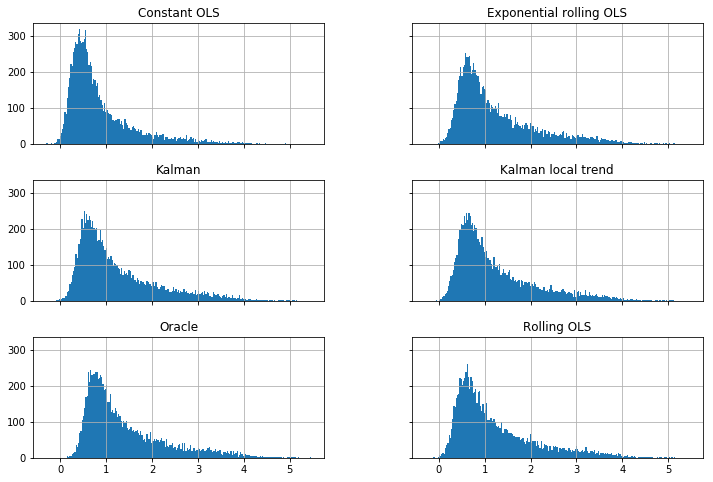

In [54]:
# Distribution of the weighted accuracies by model
axes = performance_record_wacc.iloc[:,0:].hist(bins=200, sharex=True, sharey=True, figsize=(12,8))

,Weighted accuracy,t-test differential p-value,Wilcoxon test differential p-value
Oracle,1.403647,0.000000e+00,0.000000e+00
Kalman,1.249909,1.087537e-18,4.148251e-06
Kalman local trend,1.243806,2.058902e-11,2.699031e-11
Exponential rolling OLS,1.239702,4.373699e-02,2.993450e-05
Rolling OLS,1.238170,0.000000e+00,0.000000e+00
Constant OLS,0.860735,NaN,NaN


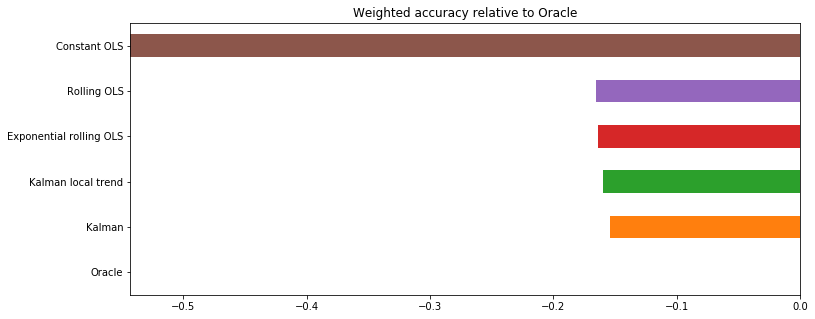

In [55]:
# Performance record for weighted accuracy
fk.performance_summary(performance_record_wacc, "Weighted accuracy")

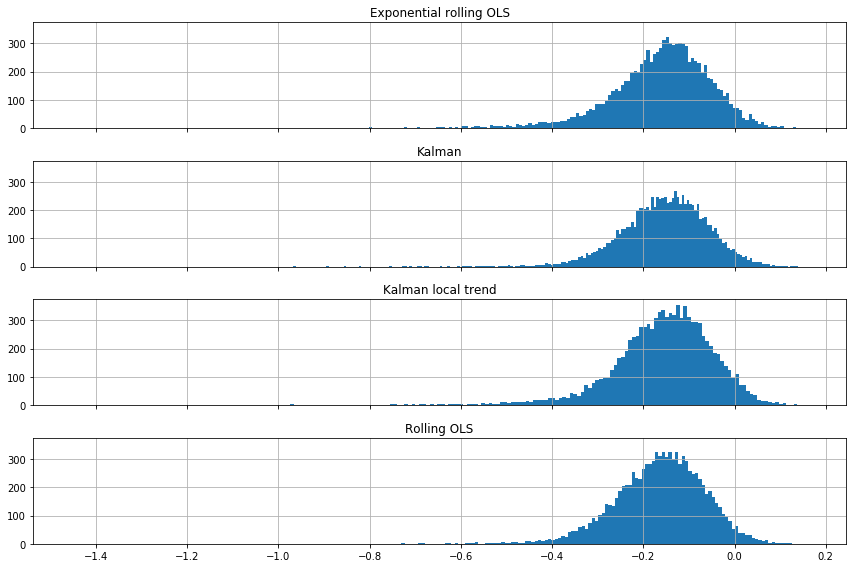

In [56]:
# Distribution of the performance difference with respect to Oracle
fk.plot_perf_differences(performance_record_wacc.iloc[:,1:], reference='Oracle')

## Mean square error (MSE)

In [57]:
# Statistics of the MSE by model
performance_record_mse.describe()

,Constant OLS,Exponential rolling OLS,Kalman,Kalman local trend,Oracle,Rolling OLS
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,103.414522,100.949899,100.842427,101.192861,99.988142,100.946679
std,4.411445,1.789350,1.627847,1.883199,1.498030,1.648022
min,94.330803,94.447724,94.556827,94.715954,94.001786,94.560811
25%,100.620529,99.761004,99.755111,99.972016,98.980425,99.854848
50%,102.232842,100.845815,100.799541,101.053513,99.988688,100.896308
75%,104.941555,101.983303,101.853952,102.217481,100.997520,101.955016
max,145.407558,111.934397,109.195298,114.290029,105.118220,110.638333


,MSE,t-test differential p-value,Wilcoxon test differential p-value
Oracle,99.988142,0.000000,0.000000e+00
Kalman,100.842427,0.000000,0.000000e+00
Rolling OLS,100.946679,0.399864,1.911243e-99
Exponential rolling OLS,100.949899,0.000000,0.000000e+00
Kalman local trend,101.192861,0.000000,0.000000e+00
Constant OLS,103.414522,NaN,NaN


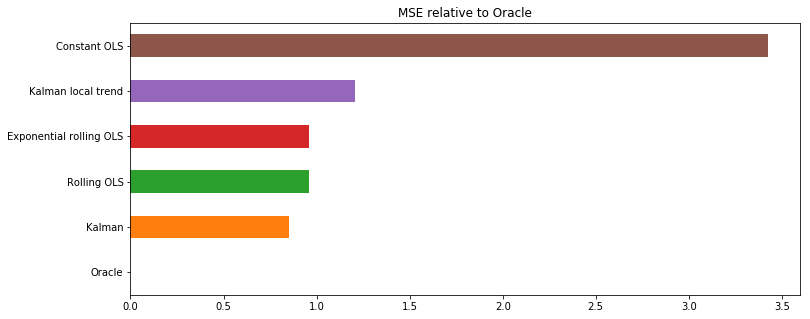

In [58]:
fk.performance_summary(performance_record_mse, "MSE")

## Save data

In [48]:
import pickle
with open('filename.pickle', 'wb') as f:
    pickle.dump({"Weighted accuracy": performance_record_wacc, "MSE": performance_record_mse}, f)

In [49]:
with open('filename.pickle', 'rb') as f:
    ls = pickle.load(f)
performance_record_wacc = ls['Weighted accuracy']
performance_record_mse = ls['MSE'] 